# Project
### "Using Machine Learning to Identify Cellular Infection of Malaria"

* [Goal](#Goal)

* [Abstact](#Abstact)

* [Extract-Classify](#Extract-Classify)

* [Extracting Cells](#Extracting-Cells)
    * [Classical Approach](#Classical-Approach)
        * [Using OpenCV](#Using-OpenCV)
        * [Using Level Set Active Contours](#Using-Level-Set-Active-Contours)
    * [Deep Learning Approach](#Deep-Learning-Approach)
        * [Using MaskRCNN](#Using-MaskRCNN)
    * [Getting a list of cells](#Getting-a-list-of-cells)
    
* [Classifying Cells](#Classifying-Cells)
    * [Dataset Creation](#Dataset-Creation)
    * [Single cell classification using fastai's RESNET CNN](#Single-cell-classification-using-fastai's-RESNET-CNN)
    * [Running on the extracted Cells](#Running-on-the-extracted-Cells)
* [Presenting Results](#Presenting-Results)
* [Summary](#Summary)

## Goal

The goal of this project is to detect cells infected with malaria in blood smear images based on a [Broad Institute dataset](#https://data.broadinstitute.org/bbbc/BBBC041/).

# Abstract

In this notebook we will present the different solutions we explored in order to achieve the [Goal](#Goal).
We will include classical image processing techniques as well as deep learning techniques.
In addition, we attempted to combine two datasets (the result of which we will shortly describe) and create our own dataset.

# Extract - Classify

Our solution approach will classify in two stages:<br>
 1. [Extract](#Extract)
 2. [Classify](#Classify)
 
 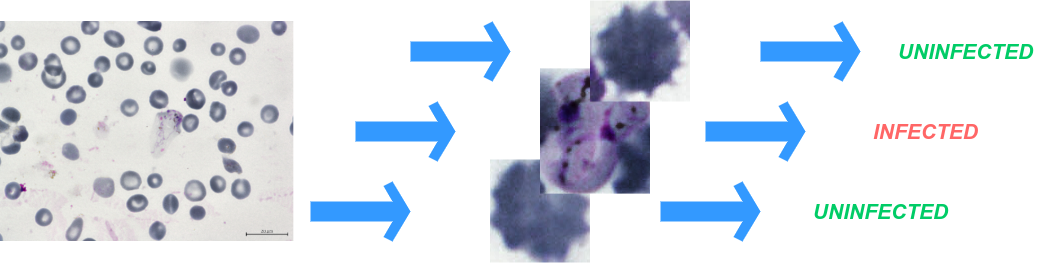

## Extract

For Cell extraction we will compare two methods:<br>
 - Deep Learning (mrcnn)
 - Object Contour (C-EPAC)

## Classify

For classification we will use a Resnet model with various training methods.<br><br>
We attempted to train the model on two different datasets:

 - [Kaggle Malaria Single Cells](#https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria/)
 - [Extracted Cells]

# Extracting Cells

## Classical Approach

## Using OpenCV

We can attempt to use edge detection with opencv to detect cells.

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
def edge_detect_image(filepath):
    img = cv2.imread(filepath)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    thresh = cv2.threshold(gray,150,255,0)
    contours, _ = cv2.findContours(thresh[1], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Create a bounding box for each contour
    for cont in contours:
           x, y, w, h = cv2.boundingRect(cont)
           cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

    img = cv2.drawContours(img, contours, -1, (255,255,0), 3)
    plt.imshow(img)


For some images, this works well

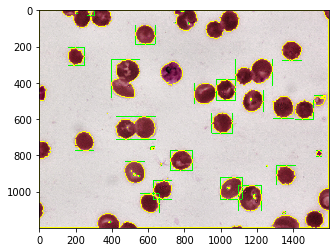

In [31]:
edge_detect_image(r"Data/malaria/images/6f4ffe7b-395f-41ea-ad61-df5e0cbd531c.png")

For others, not so much...

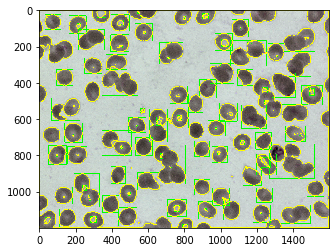

In [32]:
edge_detect_image(r"Data/malaria/images/9dc6ed5d-6698-48cf-aab3-fd156673729c.png")

This is due to two main factors:
1. The images are too different for a simple grayscale and edge threshold to handle equally.
2. Overlapping cells are taken as the same cell

For these reasons, we decided to not follow this path for cell detection.

## Using Level Set Active Contours

We would like to attempt another classical segmentation method for further comparison.<br>
The kaggle single cell dataset used in this project was created using C-EPAC - a modified version of level-set geodesic active contours [I. Estroy et al. "COUPLED EDGE PROFILE ACTIVE CONTOURS FOR RED BLOOD CELL FLOW ANALYSIS"](#http://cell.missouri.edu/media/publications/Ersoy_EPAC-red-blood-cells_ISBI-2011.pdf). 
Below we will attempt to implement the paper.


### Quick summary on the paper

The centers of the cells are found (in the paper they used iterative voting), those collection of coordinates are where the snakes start from. The snakes grow outwards till they reach the cell borders.
Conflicts in clusters of cells are resolved using methods borrowed from graph coloring, in which cells in a cluster are neighbors in the graph and two adjacent cells are to be drawn with different colors (this is done by adding a term to the velocity function which causes the snake to stop when reaches a neighbor.

### POC for active contours

Below we will use skimage for geodesic active contours (on which the paper is based).<br>
First, we will initialize some usefull functions and load the image.<br>
`store_evolution_in` will be used later to track the progress of the snake throughout the iterations.

In [1]:
%matplotlib inline
import numpy as np
from skimage import data, img_as_float
from skimage import io
from skimage.segmentation import (morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient)
from skimage.color import rgb2gray


def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store


evolution = []
callback = store_evolution_in(evolution)


fpath = '../malaria_data/malaria_culture_data/images/9dc6ed5d-6698-48cf-aab3-fd156673729c.png'
image = io.imread(fpath)
image = rgb2gray(image)

image = img_as_float(image)
gimage = inverse_gaussian_gradient(image)


/home/daniel/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


#### Snake moving inwards

Here below, we will initialize the level-set and run the algorithm.
The snake starts out as a square located 10 pixels away from the edges, seen as `init_ls_inwards[10:-10, 10:-10] = 1` and the snake will move toward the center of the image defined by setting the parameter `baloon=-1`.

In [ ]:
init_ls_inwards = np.zeros(image.shape, dtype=np.int8)
init_ls_inwards[10:-10, 10:-10] = 1

evolution_inwards = []
callback_inwards = store_evolution_in(evolution_inwards)

ls_inwards = morphological_geodesic_active_contour(gimage, 1000, init_ls_inwards,
                                           smoothing=1, balloon=-1,
                                           threshold=0.69,
                                           iter_callback=callback_inwards)

After the training is completed, we will plot the results:

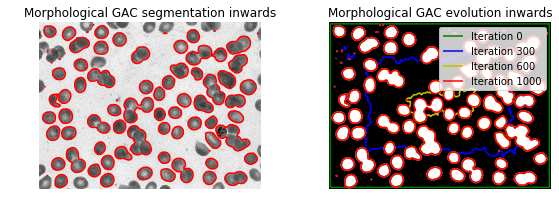

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
# ax[2].contour(ls.T[0], [0.5], colors='r')
ax[0].contour(ls_inwards, [0.5], colors='r')
ax[0].set_title("Morphological GAC segmentation inwards", fontsize=12)
ax[1].imshow(ls_inwards, cmap="gray")
ax[1].set_axis_off()

contour = ax[1].contour(evolution_inwards[0], [0.5], colors='g')
contour.collections[0].set_label("Iteration 0")
contour = ax[1].contour(evolution_inwards[300], [0.5], colors='b')
contour.collections[0].set_label("Iteration 300")
contour = ax[1].contour(evolution_inwards[600], [0.5], colors='y')
contour.collections[0].set_label("Iteration 600")
contour = ax[1].contour(evolution_inwards[-1], [0.5], colors='r')
contour.collections[0].set_label("Iteration 1000")
ax[1].legend(loc="upper right")
title = "Morphological GAC evolution inwards"
ax[1].set_title(title, fontsize=12)
fig.tight_layout()

#### Snake moving outwards

Here below we will attempt to provide a POC of the ability of the active contour algorithm to find a **single** cells contour from inside goint outwards, if this is possible and we can find the centers of the cells, we can attempt to segment all cells according to the paper.<br><br>
In this case, the snake starts out in the center of a predetermined cell for which the center was manually located `init_ls_outwards[56:72, 72:88] = 1`. Here, the parameter `baloon` is set to `1`, hence the snake will move outward. 

In [8]:
init_ls_outwards = np.zeros(image.shape, dtype=np.int8)
init_ls_outwards[56:72, 72:88] = 1
evolution_outwards = []
callback_ouotwards = store_evolution_in(evolution_outwards)

ls_outwards = morphological_geodesic_active_contour(gimage, 1000, init_ls_outwards,
                                           smoothing=1, balloon=1,
                                           threshold=0.5,
                                           iter_callback=callback_ouotwards)

Lets plot the results:

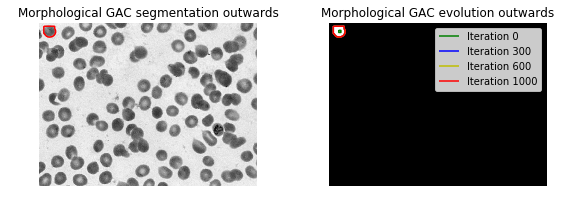

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
# ax[2].contour(ls.T[0], [0.5], colors='r')
ax[0].contour(ls_outwards, [0.5], colors='r')
ax[0].set_title("Morphological GAC segmentation outwards", fontsize=12)
ax[1].imshow(ls_outwards, cmap="gray")
ax[1].set_axis_off()

contour = ax[1].contour(evolution_outwards[0], [0.5], colors='g')
contour.collections[0].set_label("Iteration 0")
contour = ax[1].contour(evolution_outwards[300], [0.5], colors='b')
contour.collections[0].set_label("Iteration 300")
contour = ax[1].contour(evolution_outwards[600], [0.5], colors='y')
contour.collections[0].set_label("Iteration 600")
contour = ax[1].contour(evolution_outwards[-1], [0.5], colors='r')
contour.collections[0].set_label("Iteration 1000")
ax[1].legend(loc="upper right")
title = "Morphological GAC evolution outwards"
ax[1].set_title(title, fontsize=12)

fig.tight_layout()

As we can see, this is possible.

### Finding the centers

Attempting itarive voting as described in a reference in the paper did not seem feasable at the moment so we decided to attempt a different approach which we saw in one of the class lectures: **Hough Circles**<br><br>
To accomplish this we had to test many filters and hyper parameters and presented the best results we got to below.<br><br>
We took the following steps to produce the circles:
 1. Loaded the image in grayscale
 2. Applied Median Blur to that image
 3. On top of that, applied a contrast stretch with the function `pixelVal`
 4. On the resulting image, which now has a clear and high contrast, we applied canny
 5. We then applied Hough Circles transformation and found all the candidate circles.

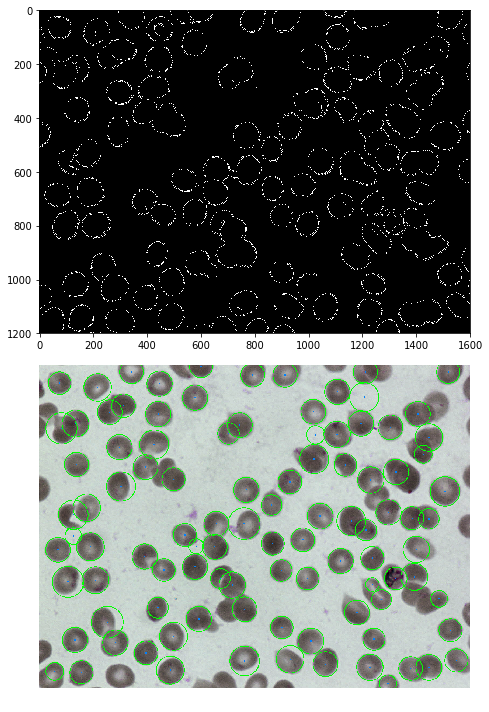

In [1]:
%matplotlib inline

import numpy as np 
import cv2 
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
ax = axes.flatten()

def draw_circles(inp_img, ax):
    
    # Initialize the list 
    Cell_count, x_count, y_count = [], [], [] 
    
    # read original image, to display the circle and center detection 
    display = cv2.imread("/home/daniel/repos/malaria_data/malaria_culture_data/images/9dc6ed5d-6698-48cf-aab3-fd156673729c.png") 
    
    # hough transform with modified circular parameters 
    
    circles = cv2.HoughCircles(inp_img, cv2.HOUGH_GRADIENT, 1.2, 50, 
                               param1 = 50, param2 = 28, minRadius = 20, maxRadius = 60) 
    
    # circle detection and labeling using hough transformation 
    if circles is not None: 
        # convert the (x, y) coordinates and radius of the circles to integers 
        circles = np.round(circles[0, :]).astype("int") 
    
            # loop over the (x, y) coordinates and radius of the circles 
        for (x, y, r) in circles: 
    
            cv2.circle(display, (x, y), r, (0, 255, 0), 2) 
            cv2.rectangle(display, (x - 2, y - 2), (x + 2, y + 2), (0, 128, 255), -1) 
            Cell_count.append(r) 
            x_count.append(x) 
            y_count.append(y) 
    
    ax.imshow(display)
    ax.set_axis_off()

        
img = cv2.imread("/home/daniel/repos/malaria_data/malaria_culture_data/images/9dc6ed5d-6698-48cf-aab3-fd156673729c.png", 0) 


def pixelVal(pix, r1, s1, r2, s2):
    if (0 <= pix and pix <= r1): 
        res = (s1 / r1) * pix 
    elif (r1 < pix and pix <= r2): 
        res = ((s2 - s1) / (r2 - r1)) * (pix - r1) + s1 
    else: 
        res = ((255 - s2) / (255 - r2)) * (pix - r2) + s2
    res_im = np.array(res, dtype = np.uint8)
    return res_im
  
  
  
r1 = 70
s1 = 0
r2 = 200
s2 = 255
  
# Vectorize the function to apply it to each value in the Numpy array.  
pixelVal_vec = np.vectorize(pixelVal) 
  
blurM = cv2.medianBlur(img, 7)
contrast_stretched_blurM = pixelVal_vec(blurM, r1, s1, r2, s2)
canny = cv2.Canny(contrast_stretched_blurM, 100, 200)

selected_image = canny
ax[0].imshow(selected_image, cmap='gray')
draw_circles(selected_image, ax[1])


fig.tight_layout() 


Above, we plotted two images: 
 1. the canny image on which the hough circles was applied
 2. The resulting images with circles around all the detected cells
 <br><br>
These results are quite impressive, but not good enough  for our case since there are still some False Negatives and False Positives.

### Why we decided to abandon this approach

Given enough time we would eventually be able to come up with sufficient results. Unfortunately we do not have enough time to complete this path. The deep learning approach is simple to implement and provides excellent results, hence we will proceed with it for cell segmentation.

## Deep Learning Approach

## Using MaskRCNN

We can use MaskRCNN to use transfer learning from a premade model called mask_rcnn_coco. We can load this weight model and retrain several layers only - this way we reduce the amount of time to run the training.

Let's setup the imports for MRCNN

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.utils import Dataset
from matplotlib import pyplot
%matplotlib inline
from matplotlib.patches import Rectangle
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
import json

Using TensorFlow backend.


There are warning messages to let us know we're using an out-dated tensorflow package - this is known and intentional, so that we won't be overflowed with logs, we will lower the logging level to ERROR.

In [3]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

We can set the globals to the data.

In [4]:
BASE_DIR = 'Data\\malaria'

TRAINING_JSON = os.path.join(BASE_DIR, 'training.json')

TRAINING_IMG_COUNT = 100
TESTING_IMG_COUNT = 50

Here we can define the cell culture dataset that we use.
It loads the images as required and extracts the bounding box metadata from the training data if needed.
We can define how many images we want via the globals in the previous section.

In [5]:
class CellCultureDataset(Dataset):
    def load_json_data(self):
        self.data = json.load(open(TRAINING_JSON))
    def load_dataset(self, is_train=True):
        
        self.add_class("dataset", 1, "cellculture")
        count = -1
        for training_image in self.data:
            count += 1
            if is_train and count > TRAINING_IMG_COUNT:
                continue
            if not is_train and count <= TRAINING_IMG_COUNT:
                continue
            if count > TRAINING_IMG_COUNT + TESTING_IMG_COUNT:
                break
            img_id = training_image['image']['pathname'][8:-4]
            image_path = os.path.join(BASE_DIR, training_image['image']['pathname'][1:].replace('/', '\\'))
            self.add_image('dataset', image_id=img_id, path=image_path, annotation=training_image)

    def load_mask(self, image_id):
        boxes, w, h = self.extract_boxes(self.image_info[image_id]['annotation'])
        
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        class_ids = []
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('cellculture'))
        return masks, asarray(class_ids, dtype='int32')

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def extract_boxes(self, bbox_data):
        bboxes = []
        for bbox in bbox_data['objects']:
            xmin = bbox['bounding_box']['minimum']['c']
            ymin = bbox['bounding_box']['minimum']['r']
            xmax = bbox['bounding_box']['maximum']['c']
            ymax = bbox['bounding_box']['maximum']['r']
            bboxes.append([xmin, ymin, xmax, ymax])
        img_width = bbox_data['image']['shape']['c']
        img_height = bbox_data['image']['shape']['r']
        return bboxes, img_width, img_height

Now we can setup the config classes needed for training the model.

In [6]:
class CellCultureConfig(Config):
    NAME = "cellculture_cfg"
    NUM_CLASSES = 1 + 1
    STEPS_PER_EPOCH = TRAINING_IMG_COUNT + 1

Now we can actually train the model - this took several hours to run.

In [7]:
def train_model(train_set, test_set):
    print('Train: %d' % len(train_set.image_ids))
    print('Test: %d' % len(test_set.image_ids))
    config = CellCultureConfig()
    model = MaskRCNN(mode='training', model_dir='./', config=config)
    model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
    # train weights (output layers or 'heads')
    model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')

Now that we have our model trained, 'mask_rcnn_cellculture_cfg_0005.h5', we can make predictions :)

Let's setup the required config.

In [8]:
class PredictionConfig(Config):
    NAME = "cellculture_cfg"
    NUM_CLASSES = 1 + 1
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

So we have our model trained - but can we somehow evalutate it's accuracy?

We can attempt to by calculating all the APs across the board and getting the mean AP. Let's do this for both the training set and the test set.

In [9]:
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        # calculate statistics, including AP
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        # store
        APs.append(AP)
    # calculate the mean AP across all images
    mAP = mean(APs)
    return mAP

def eval_map(train_set, test_set):
    cfg = PredictionConfig()
    # define the model
    model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
    # load model weights
    model.load_weights('mask_rcnn_cellculture_cfg_0005.h5', by_name=True)
    # evaluate model on training dataset
    train_mAP = evaluate_model(train_set, model, cfg)
    print("Train mAP: %.3f" % train_mAP)
    # evaluate model on test dataset
    test_mAP = evaluate_model(test_set, model, cfg)
    print("Test mAP: %.3f" % test_mAP)

Creation of the train and test set.

In [27]:
train_set = CellCultureDataset()
train_set.load_json_data()
train_set.load_dataset()
train_set.prepare()

test_set = CellCultureDataset()
test_set.load_json_data()
test_set.load_dataset(is_train=False)
test_set.prepare()

Running this also takes some time...

In [12]:
eval_map(train_set, test_set)

Train mAP: 0.805
Test mAP: 0.765


Now that we've seen the evaluation of the model, we can finally make some predictions.

Let's create a function to take annotatted images and display them side by side with the predictions.

In [10]:
def plot_actual_vs_predicted(dataset, model, cfg, n_images=3):
    # load image and mask
    for i in range(n_images):
        # load the image and mask
        image = dataset.load_image(i)
        mask, _ = dataset.load_mask(i)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)[0]
        # define subplot
        pyplot.subplot(n_images, 2, i*2+1)
        # plot raw pixel data
        pyplot.imshow(image)
        extracted_bboxes = dataset.extract_boxes(dataset.image_info[i]['annotation'])[0]
        pyplot.title('Actual - %d cells' % len(extracted_bboxes))
        bx = pyplot.gca()
        # plot each box
        for box in extracted_bboxes:
            # get coordinates
            x1, y1, x2, y2 = box
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            # draw the box
            bx.add_patch(rect)
        # get the context for drawing boxes
        pyplot.subplot(n_images, 2, i*2+2)
        # plot raw pixel data
        pyplot.imshow(image)
        pyplot.title('Predicted - %d cells' % len(yhat['rois']))
        ax = pyplot.gca()
        # plot each box
        for box in yhat['rois']:
            # get coordinates
            y1, x1, y2, x2 = box
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            # draw the box
            ax.add_patch(rect)
    # show the figure
    pyplot.show()

Let's load 3 images from the training set and 3 images from the test set (that also have known annotations) and compare them.

In [11]:
def make_prediction(train_set, test_set):
    cfg = PredictionConfig()
    # define the model
    model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
    # load model weights
    model_path = 'mask_rcnn_cellculture_cfg_0005.h5'
    model.load_weights(model_path, by_name=True)
    # plot predictions for train dataset
    plot_actual_vs_predicted(train_set, model, cfg)
    # plot predictions for test dataset
    plot_actual_vs_predicted(test_set, model, cfg)

The upper 3 images are taken from the training set, the lower 3 are from the test set.

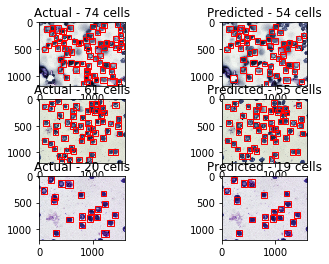

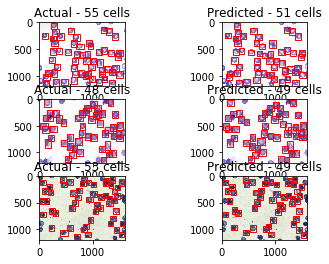

In [32]:
make_prediction(train_set, test_set)

Now we want to able to call the prediction on a given image, there is some code duplication, but this is unavoidable in this circumstance.

In [12]:
def plot_predited_given_image(model, cfg, image_path):
    # Add Image to dataset
    dataset = CellCultureDataset()
    dataset.load_json_data()
    dataset.add_class("dataset", 1, "cellculture")

    wanted_image = None
    for img in dataset.data:
        if img['image']['pathname'] == image_path:
            wanted_image = img
    if wanted_image == None:
        raise ValueError("Unknown image %s" % image_path)

    img_id = 0
    image_path = os.path.join(BASE_DIR, wanted_image['image']['pathname'][1:].replace('/', '\\'))
    dataset.add_image('dataset', image_id=img_id, path=image_path, annotation=wanted_image)
    dataset.prepare()

    # load the image and mask
    image = dataset.load_image(img_id)
    mask, _ = dataset.load_mask(img_id)
    # convert pixel values (e.g. center)
    scaled_image = mold_image(image, cfg)
    # convert image into one sample
    sample = expand_dims(scaled_image, 0)
    # make prediction
    yhat = model.detect(sample, verbose=0)[0]
    # plot raw pixel data
    pyplot.imshow(image)
    pyplot.title('Predicted - %d cells' % len(yhat['rois']))
    ax = pyplot.gca()
    # plot each box
    for box in yhat['rois']:
        # get coordinates
        y1, x1, y2, x2 = box
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
    # show the figure
    pyplot.show()
    
def make_prediction_single(image_path):
    cfg = PredictionConfig()
    # define the model
    model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
    # load model weights
    model_path = 'mask_rcnn_cellculture_cfg_0005.h5'
    model.load_weights(model_path, by_name=True)
    plot_predited_given_image(model, cfg, image_path)

Let's call some predictions on images.

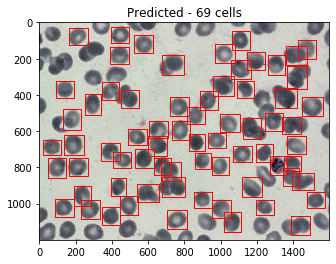

In [11]:
make_prediction_single(r"/images/9dc6ed5d-6698-48cf-aab3-fd156673729c.png")

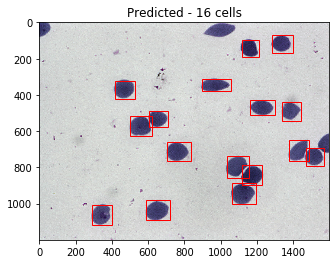

In [34]:
make_prediction_single(r"/images/2afe2750-c963-46f9-a1ad-9260e80679ca.png")

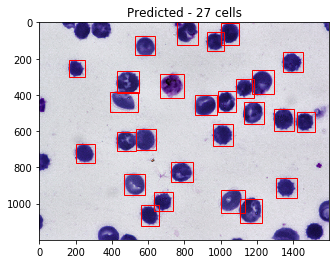

In [20]:
make_prediction_single(r"/images/6f4ffe7b-395f-41ea-ad61-df5e0cbd531c.png")

We can see the some images are better than others - but overall we have a good amount of cell detection.

## Getting a list of cells

In [41]:
def get_predicted_cells(model, cfg, image_path):
    # Add Image to dataset
    dataset = CellCultureDataset()
    dataset.load_json_data()
    dataset.add_class("dataset", 1, "cellculture")

    wanted_image = None
    for img in dataset.data:
        if img['image']['pathname'] == image_path:
            wanted_image = img
    if wanted_image == None:
        raise ValueError("Unknown image %s" % image_path)

    img_id = 0
    image_path = os.path.join(BASE_DIR, wanted_image['image']['pathname'][1:].replace('/', '\\'))
    dataset.add_image('dataset', image_id=img_id, path=image_path, annotation=wanted_image)
    dataset.prepare()

    # load the image and mask
    image = dataset.load_image(img_id)
    mask, _ = dataset.load_mask(img_id)
    # convert pixel values (e.g. center)
    scaled_image = mold_image(image, cfg)
    # convert image into one sample
    sample = expand_dims(scaled_image, 0)
    # make prediction
    yhat = model.detect(sample, verbose=0)[0]

    detected_cells = []
    for box in yhat['rois']:
        # get coordinates
        y1, x1, y2, x2 = box
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        detected_cells.append((box, image[y1:y1+height, x1:x1+width]))
    return detected_cells
    
def get_predicted_cells_from_image(image_path):
    cfg = PredictionConfig()
    # define the model
    model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
    # load model weights
    model_path = 'mask_rcnn_cellculture_cfg_0005.h5'
    model.load_weights(model_path, by_name=True)
    return get_predicted_cells(model, cfg, image_path)


22 cells:


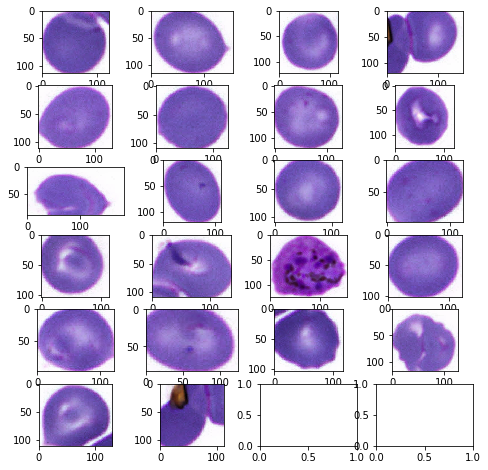

In [50]:
cells = get_predicted_cells_from_image(r"/images/4767bfcc-fe87-4962-8c40-6ce8d9363cdf.png")
print("%d cells:" % len(cells))
_, axarray = pyplot.subplots(int(len(cells)/4)+1, 4, figsize=(8,8))
ax = axarray.flatten()

for i in range(len(cells)):
    ax[i].imshow(cells[i][1])


# Classifying Cells

## Dataset Creation

In order to train a classifier on single cells, we had to create a new training set out of the blood smear images.<br>
Due to imbalanced data, we had to limit the number of uninfected cells in our training data.<br>
The code can be found [here](https://github.com/fensterheim/OpenUDataScienceProj/blob/master/Project/seperate_images.py).

In [55]:
from seperate_images import seperate_images

seperate_images(img_count=5000)

## Single cell classification using fastai's RESNET CNN

fastai is an opensource deep learning package developed by Jeremy Howard.
The purpose of this framework is to ease the ability of developing deep learning while focusing on some key training methods (such as transfer learning, learning rate annealing and others).
<br><br>
We will use fastai's Resnet: a CNN architecture that attempts to overcome the 'vanishing gradient' problem by creating 'identity shortcuts' which adds outputs from layers to inputs to later layers activation functions.
<br><br>
Resnets are impirically shown to greatly improve performance over 'plain networks' (those without the shortcuts).

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fastai2.data.all import Path, RandomSplitter, Normalize, get_image_files, parent_label, DataBlock, CategoryBlock
from fastai2.vision.all import Resize, aug_transforms, imagenet_stats, ImageBlock, cnn_learner, xresnet34
from fastai2.interpret import ClassificationInterpretation
from fastai2.metrics import accuracy

from sklearn.metrics import auc, roc_curve, precision_recall_curve, classification_report

import os
print(os.listdir("separated/"))

['infected', 'uninfected']


In [10]:
path=Path('separated/')
path.ls()

(#2) [Path('separated/uninfected'),Path('separated/infected')]

In [9]:
splitter = RandomSplitter()
item_tfms = [Resize(224)]
batch_tfms=[*aug_transforms(flip_vert=True,max_zoom=1.2, max_warp=0), Normalize.from_stats(*imagenet_stats)]

In [14]:
data_block = DataBlock(blocks=[ImageBlock, CategoryBlock],
                  get_items=get_image_files,
                  get_y=parent_label,
                  splitter=splitter,
                  item_tfms=item_tfms)

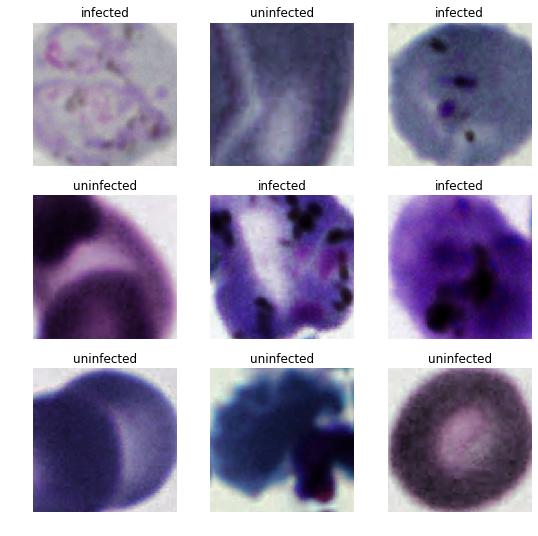

In [13]:
data = data_block.dataloaders(path, bs=64)
data.show_batch()

In [27]:
learn.fine_tune(15)learn = cnn_learner(data, xresnet34, metrics=[accuracy]).to_fp16()

In [ ]:
learn.fine_tune(15)

In [0]:
learn.save('stage-1')

In [ ]:
learn.export('xrsnet_34_singlecell_extracted.pkl')

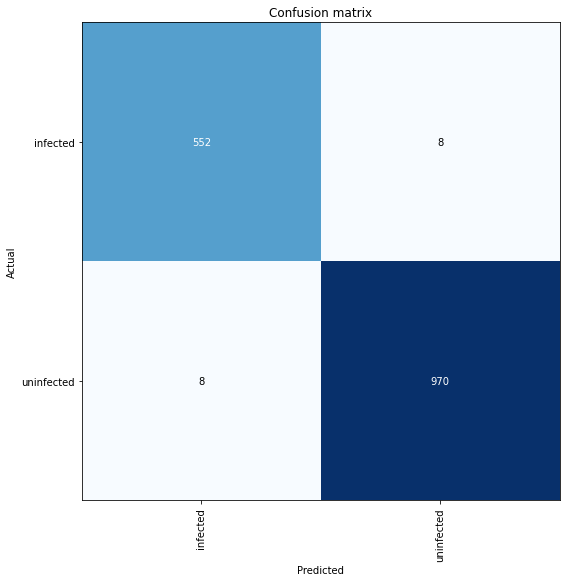

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,8))

In [18]:
preds, y_true=learn.get_preds()
y_true.shape, preds.shape

(torch.Size([1538]), torch.Size([1538, 2]))

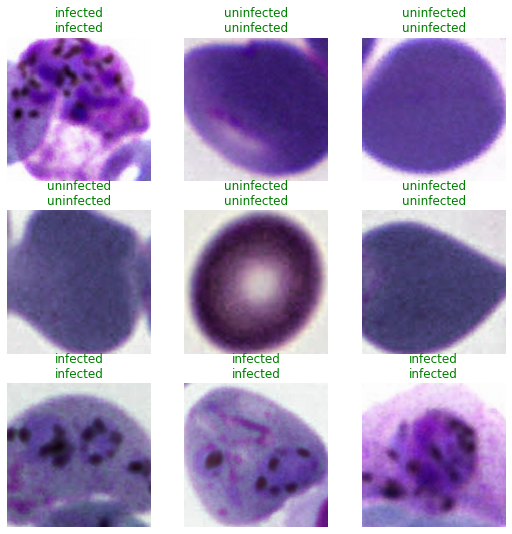

In [19]:
learn.show_results()

In [29]:
y_true=y_true.numpy() 
preds=np.argmax(preds.numpy(), axis=-1)
y_true.shape, preds.shape

((1538,), (1538,))

In [30]:
classes = list(data.vocab)
report = classification_report(y_true, preds, target_names=classes)
print(report)

              precision    recall  f1-score   support

    infected       0.99      0.99      0.99       560
  uninfected       0.99      0.99      0.99       978

    accuracy                           0.99      1538
   macro avg       0.99      0.99      0.99      1538
weighted avg       0.99      0.99      0.99      1538



## Running on the extracted Cells

Here we can see the prediction for each cell as per our trained model.

D:\Users\Joseph\anaconda3\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


('uninfected', tensor(1), tensor([7.6523e-04, 9.9923e-01]))


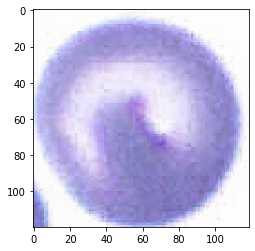

('uninfected', tensor(1), tensor([5.1762e-06, 9.9999e-01]))


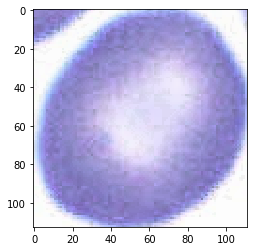

('uninfected', tensor(1), tensor([1.0821e-05, 9.9999e-01]))


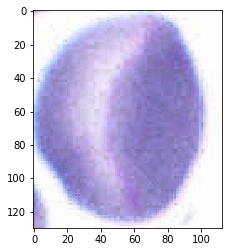

('uninfected', tensor(1), tensor([1.1029e-04, 9.9989e-01]))


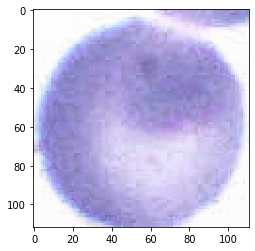

('uninfected', tensor(1), tensor([8.3583e-06, 9.9999e-01]))


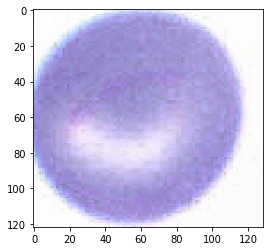

('uninfected', tensor(1), tensor([1.3174e-05, 9.9999e-01]))


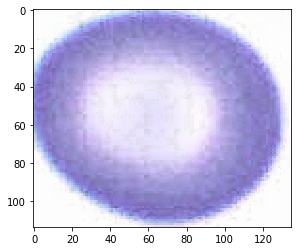

('uninfected', tensor(1), tensor([1.2738e-04, 9.9987e-01]))


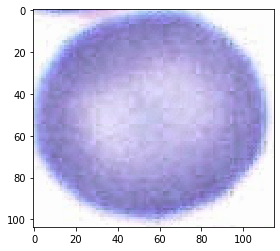

('uninfected', tensor(1), tensor([1.7975e-04, 9.9982e-01]))


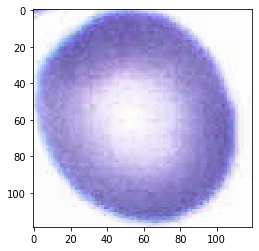

('uninfected', tensor(1), tensor([2.3345e-04, 9.9977e-01]))


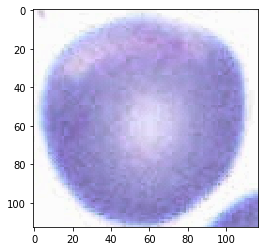

('uninfected', tensor(1), tensor([4.4022e-05, 9.9996e-01]))


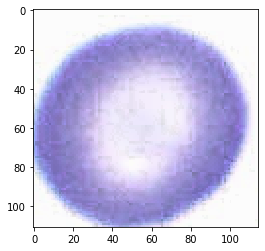

('uninfected', tensor(1), tensor([1.7231e-04, 9.9983e-01]))


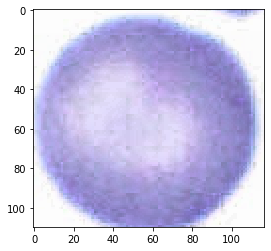

('uninfected', tensor(1), tensor([0.0023, 0.9977]))


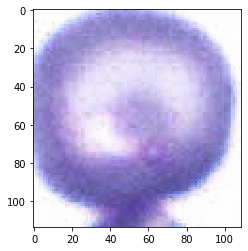

('uninfected', tensor(1), tensor([1.9320e-05, 9.9998e-01]))


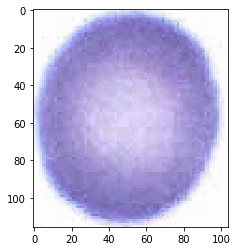

('uninfected', tensor(1), tensor([1.0612e-04, 9.9989e-01]))


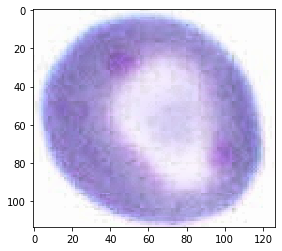

('uninfected', tensor(1), tensor([3.1746e-05, 9.9997e-01]))


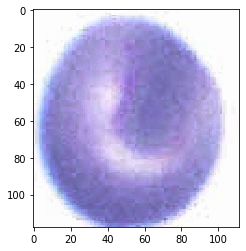

('uninfected', tensor(1), tensor([3.1241e-05, 9.9997e-01]))


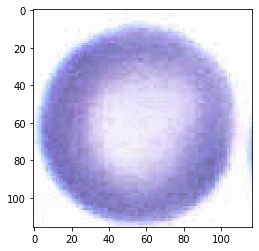

('uninfected', tensor(1), tensor([3.5759e-06, 1.0000e+00]))


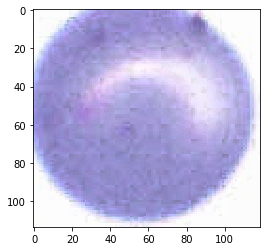

('uninfected', tensor(1), tensor([3.2545e-04, 9.9967e-01]))


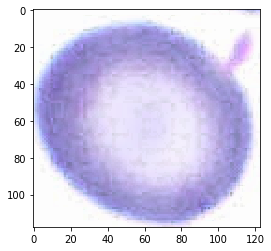

('uninfected', tensor(1), tensor([1.6007e-04, 9.9984e-01]))


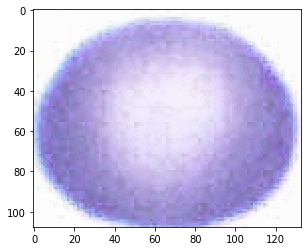

('uninfected', tensor(1), tensor([1.6784e-06, 1.0000e+00]))


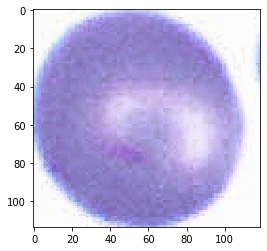

('uninfected', tensor(1), tensor([1.7817e-04, 9.9982e-01]))


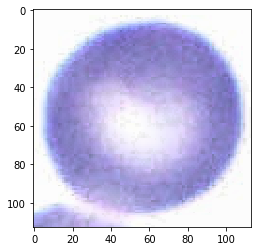

('uninfected', tensor(1), tensor([3.0765e-04, 9.9969e-01]))


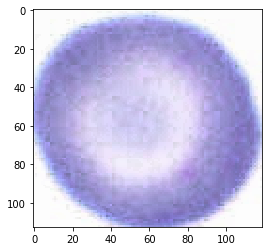

('uninfected', tensor(1), tensor([4.7490e-04, 9.9953e-01]))


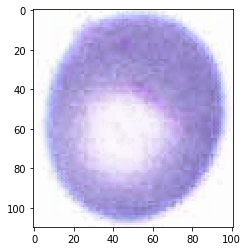

('uninfected', tensor(1), tensor([4.8909e-06, 1.0000e+00]))


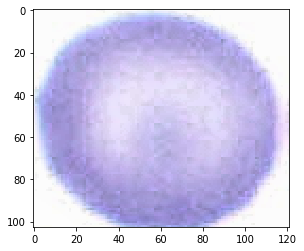

('uninfected', tensor(1), tensor([6.2303e-04, 9.9938e-01]))


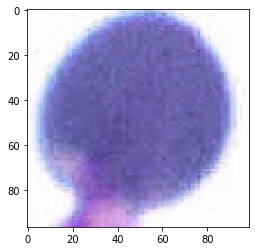

('uninfected', tensor(1), tensor([4.0929e-06, 1.0000e+00]))


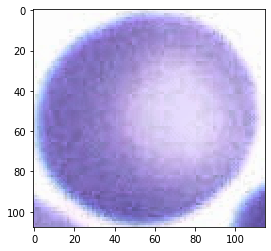

('uninfected', tensor(1), tensor([7.5581e-06, 9.9999e-01]))


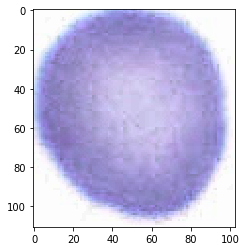

('uninfected', tensor(1), tensor([4.5583e-04, 9.9954e-01]))


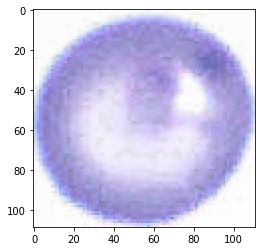

('uninfected', tensor(1), tensor([3.0675e-04, 9.9969e-01]))


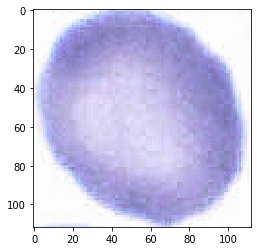

('uninfected', tensor(1), tensor([1.4314e-04, 9.9986e-01]))


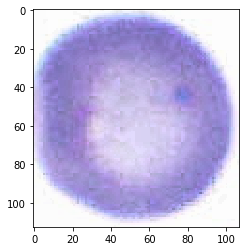

('uninfected', tensor(1), tensor([9.1947e-06, 9.9999e-01]))


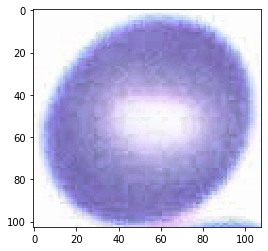

('uninfected', tensor(1), tensor([8.9026e-06, 9.9999e-01]))


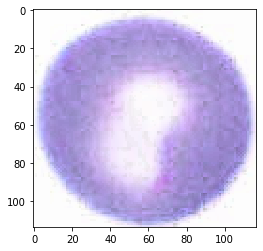

('uninfected', tensor(1), tensor([5.1075e-05, 9.9995e-01]))


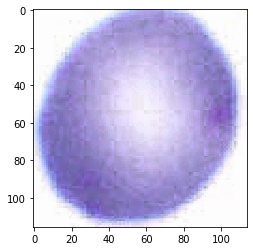

('uninfected', tensor(1), tensor([3.5071e-04, 9.9965e-01]))


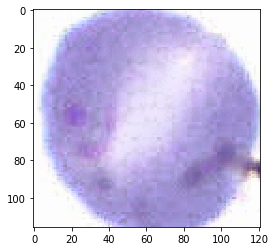

('uninfected', tensor(1), tensor([6.3571e-05, 9.9994e-01]))


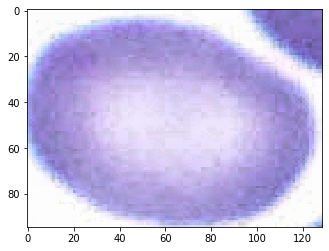

('uninfected', tensor(1), tensor([2.1178e-05, 9.9998e-01]))


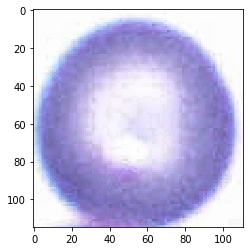

('uninfected', tensor(1), tensor([1.1907e-04, 9.9988e-01]))


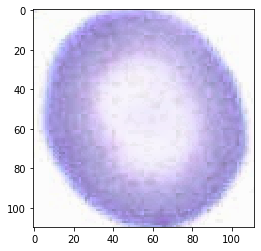

('uninfected', tensor(1), tensor([1.8542e-05, 9.9998e-01]))


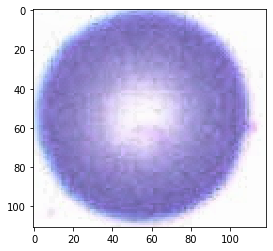

('uninfected', tensor(1), tensor([7.5399e-04, 9.9925e-01]))


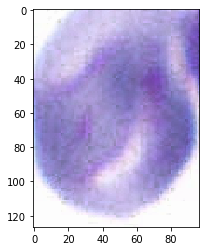

('uninfected', tensor(1), tensor([1.8341e-05, 9.9998e-01]))


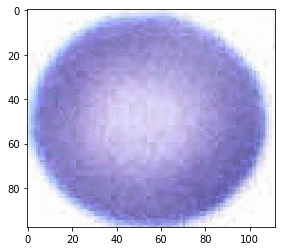

('uninfected', tensor(1), tensor([1.5892e-04, 9.9984e-01]))


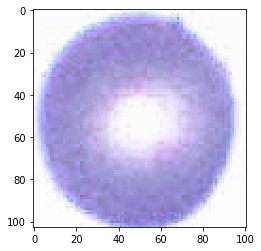

('uninfected', tensor(1), tensor([3.4565e-04, 9.9965e-01]))


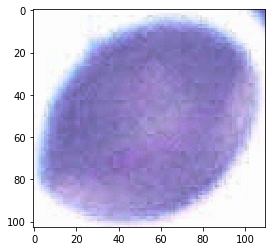

('uninfected', tensor(1), tensor([5.7593e-05, 9.9994e-01]))


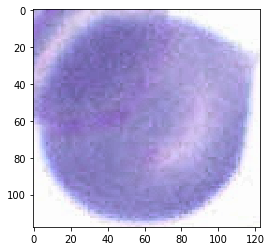

('infected', tensor(0), tensor([0.9296, 0.0704]))


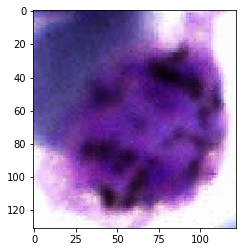

('uninfected', tensor(1), tensor([5.1125e-05, 9.9995e-01]))


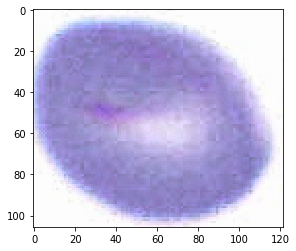

('infected', tensor(0), tensor([0.9918, 0.0082]))


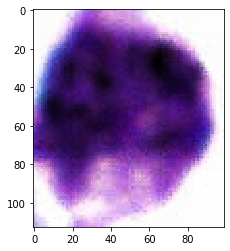

('uninfected', tensor(1), tensor([2.0351e-05, 9.9998e-01]))


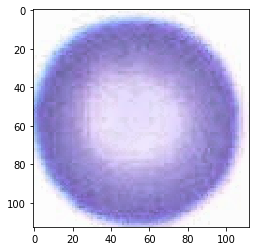

('uninfected', tensor(1), tensor([5.4838e-04, 9.9945e-01]))


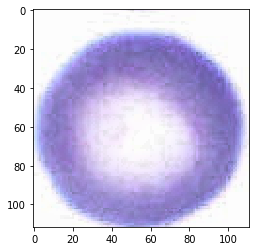

('uninfected', tensor(1), tensor([6.6560e-05, 9.9993e-01]))


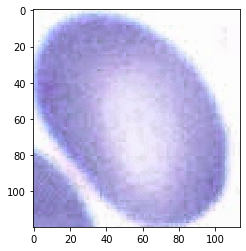

('uninfected', tensor(1), tensor([2.6511e-05, 9.9997e-01]))


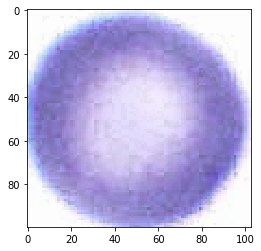

('uninfected', tensor(1), tensor([2.9271e-04, 9.9971e-01]))


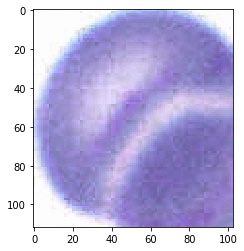

('uninfected', tensor(1), tensor([0.0045, 0.9955]))


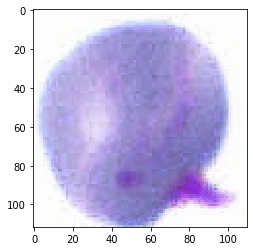

('uninfected', tensor(1), tensor([7.8760e-06, 9.9999e-01]))


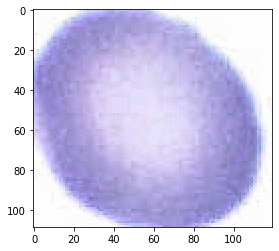

('uninfected', tensor(1), tensor([5.1775e-06, 9.9999e-01]))


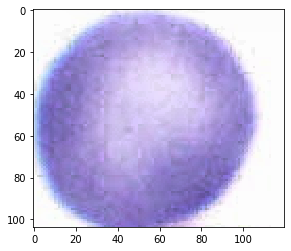

('uninfected', tensor(1), tensor([8.1919e-05, 9.9992e-01]))


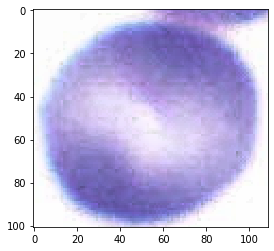

('uninfected', tensor(1), tensor([7.1013e-05, 9.9993e-01]))


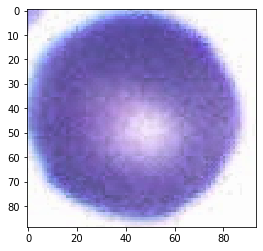

('uninfected', tensor(1), tensor([4.1834e-05, 9.9996e-01]))


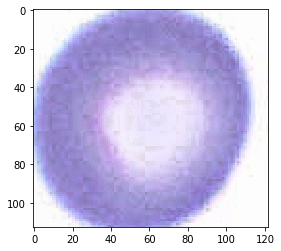

('uninfected', tensor(1), tensor([1.0110e-05, 9.9999e-01]))


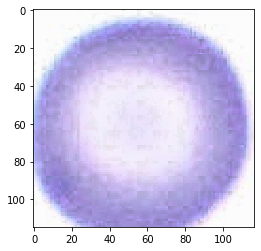

('uninfected', tensor(1), tensor([1.7195e-04, 9.9983e-01]))


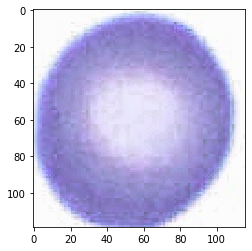

('uninfected', tensor(1), tensor([3.6015e-05, 9.9996e-01]))


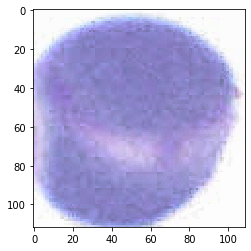

In [65]:
from fastai2.vision.all import load_learner

filename = r"/images/53afd70c-08a7-4b9a-b137-7003b2ecbeab.png"
single_preset_learner = load_learner("xrsnet_34_singlecell_extracted.pkl")
cells = get_predicted_cells_from_image(filename)

for cell in cells:
    print(single_preset_learner.predict(cell[1]))
    pyplot.imshow(cell[1])
    pyplot.show()

Since we don't actually need to see each cell, just the total - we can show itas a percentage of the total cells.

## Presenting Results

First we can make a function that will return the data we want given an image.

In [102]:
def make_prediction(img_filename):
    preset_learner = load_learner("xrsnet_34_singlecell_extracted.pkl")
    cells = get_predicted_cells_from_image(img_filename)
    parasitized = []
    uninfected  = []

    for cell in cells:
        # Disable the progress bar
        with preset_learner.no_bar():
            cell_type, _, _ = preset_learner.predict(cell[1])
        if cell_type != 'uninfected':
            parasitized.append(cell)
        else:
            uninfected.append(cell)
    return (parasitized, uninfected)

And calling it would look like this

In [105]:
filename = r"/images/53afd70c-08a7-4b9a-b137-7003b2ecbeab.png"
data = make_prediction(filename)
count_para  = len(data[0])
count_uninf = len(data[1])
print(filename)
print("Cells %d, Parasitized %d, Uninfected %d" % (count_para+count_uninf, count_para, count_uninf))

/images/53afd70c-08a7-4b9a-b137-7003b2ecbeab.png
Cells 60, Parasitized 2, Uninfected 58


It would be better to visualize the success of the detection by overlaying the result on the original image.

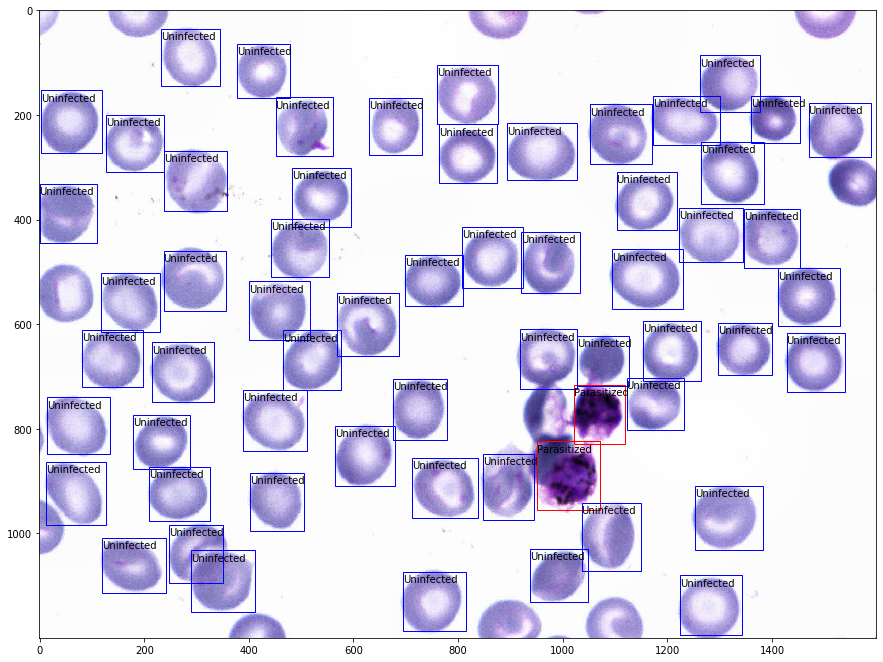

In [113]:
pyplot.figure(figsize=(15, 15))
img = pyplot.imread(BASE_DIR + '//' + filename)
pyplot.imshow(img)

ax = pyplot.gca()
# Plot boxes for Parasitized
for box in data[0]:
    # get coordinates
    y1, x1, y2, x2 = box[0]
    # calculate width and height of the box
    width, height = x2 - x1, y2 - y1
    # create the shape
    rect = Rectangle((x1, y1), width, height, fill=False, color='red')
    # draw the box
    ax.annotate("Parasitized", xy=(x1,y1+20))
    ax.add_patch(rect)
    
# Plot boxes for Uninfected
for box in data[1]:
    # get coordinates
    y1, x1, y2, x2 = box[0]
    # calculate width and height of the box
    width, height = x2 - x1, y2 - y1
    # create the shape
    rect = Rectangle((x1, y1), width, height, fill=False, color='blue')
    # draw the box
    ax.annotate("Uninfected", xy=(x1,y1+20))
    ax.add_patch(rect)
    
# show the figure
pyplot.show()

## Summary

In this project we've seen why malaria is such a problem and why it is important to solve it efficiently.<br>
We've found several datasets that helped us achieve a possible solution under some assumptions.<br>
Finally, we've created a simple UI that can recieve an image, find the cells, classify them and output the result in a easy-to-use way.

This can be easily adapted to work over the internet and can serve predictions at a high rate in both our key performance indicators: concurrent users and accuracy.

Overall we faced several technological challenges: getting a dataset that can be used well; actually succeeding in training a model that predicts well without high powered machines; solving coding issues with out of sync versions of python packages.

We overcame these challenges by using our combined knowledge and good amount of googling. :)

We condsider this project a success since we completed the goals we set out in the beggining - and have good looking results to show.